In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
from source.interference_reject import InterferenceReject
from source.reader import read_raw
from source.gridding import NFFT
from source.combine import CoilCombo

%matplotlib inline

## Data import

In [2]:
file_name = "../data/fse_phantom.h5"
data, index, metadata = read_raw(file_name)
# Channel definitions
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
# Encoding
matrix_size = metadata['sequence']['encoding']['matrix_size']
k_x = index['scan']['encoding_1']
k_y = index['scan']['encoding_2']
k_2d = np.pi * np.vstack((k_x, k_y)).T

## Interference rejection

In [3]:
data_scan = data['scan']
data_prescan = data['noise']
# Dynamic correction with k-space weighting
lines_per_bin = 100
num_lines_acq = data_scan.shape[0]
num_bins = int(np.ceil(num_lines_acq / lines_per_bin))
lines_per_bin = int(np.round(num_lines_acq / num_bins))
bin_index = lines_per_bin * np.arange(num_bins)
bin_index = np.concatenate((bin_index, [num_lines_acq - 1]))
rej_weighted = InterferenceReject(
    use_weights=True,
    channels_signal=num_channels_signal,
    channels_all=num_channels_all,
    num_freq_bins=matrix_size[0],
)
data_cor = np.zeros([data_scan.shape[0], num_channels_signal, data_scan.shape[2]], dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_cor[sel_bin, :, :] = rej_weighted.apply(scan_raw=data_scan[sel_bin, :, :], k_coords=k_2d[sel_bin, :])


## Fourier reconstruction

In [4]:
# Apply readout FT
spec_cor = np.fft.fftshift(np.fft.fft(data_cor, axis=-1), axes=-1)
# Apply non-uniform FT
encode_op = NFFT(k_coords=k_2d, image_size=matrix_size[1:], n_channels=num_channels_signal)
dims_4d = np.concatenate((matrix_size, [num_channels_signal]))
im4d_cor = np.zeros(dims_4d, dtype=np.complex64)
for _f in range(spec_cor.shape[-1]):
    im4d_cor[_f, :, :, :] = encode_op.adjoint(spec_cor[:, :, _f])

## Coil combine

In [6]:
# Get data for prewhitening using weighted k-space
wr = np.linspace(0, 1, spec_cor.shape[-1]) - 0.5
wr = 1 - np.exp(-50 * wr ** 2)
wp = 1 - np.exp(-50 * np.sum(k_2d ** 2, axis=1))
w_all = np.dot(wr[:, np.newaxis], wp[:, np.newaxis].T)
w_all = np.transpose(np.tile(w_all[:, :, np.newaxis], num_channels_signal), [1, 2, 0])
data_prewhite = data_cor * w_all

comb_complex = CoilCombo(matrix_size=matrix_size, noise_data=data_prewhite)
im_sos = comb_complex.forward(im4d_cor, flag_prewhite=False, mode='SoS')
im_sos_pw = comb_complex.forward(im4d_cor, flag_prewhite=True, mode='SoS')
im_adapt = comb_complex.forward(im4d_cor, flag_prewhite=True, mode='adaptive')

Interpolate dimension 0 from 134 to 136
Size of patchy data (34, 33, 9, 4, 4, 4, 8)
interpolate to initial size


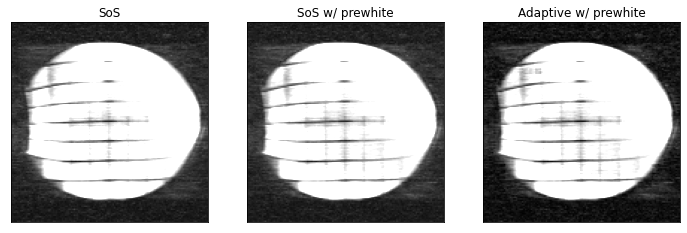

In [12]:
# Plot data
slc = 17
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax[0].set_title("SoS")
ax[0].imshow(np.abs(im_sos[:, :, slc]), cmap='gray', vmin=0, vmax=0.25 * np.max(np.abs(im_sos)))
ax[1].set_title("SoS w/ prewhite")
ax[1].imshow(np.abs(im_sos_pw[:, :, slc]), cmap='gray', vmin=0, vmax=0.25 * np.max(np.abs(im_sos_pw)))
ax[2].set_title("Adaptive w/ prewhite")
ax[2].imshow(np.abs(im_adapt[:, :, slc]), cmap='gray', vmin=0, vmax=0.25 * np.max(np.abs(im_adapt)))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
# fig.savefig("methods_rejection_image.tif", dpi=600, format="tiff")